# Basics of Reading and Writing Spatial Data


In the section, we describe basic techniques for reading and writing spatial data in several common formats.  First, we provide some background on spatial data formats, and then we'll demonstrate code for reading and writing some common formats.   

### Representation of Spatial Data

Generallyspeaking, spatial data generally comes in two fundamental formats, raster and vector. 

- **Raster** data can be thought of as a grid, where each point in the grid stores a data value of interest. Digital images (and satellite imagery) are an example of raster data.  Another common example relevant to ecological engineering are Digital Elevation Models (DEM) that provide elevations of a land surface across a regularly spaced grid.  Geometric information is generally specified by establishing a corner and cell size.  

- **Vector** data is generally associated with points, lines, or polygon "features" that map to real-world objects, like transportation networks and taxlots.  Vector data is described by both a *geometry* containing information about the geometric shape of the feature, and an *attribute set* that contains additional information about the feature, generally conforming to a record in a database table.

Within these two broad classes of spatial data representation, many specific file formats exist.
Each type of data requires appropriate handing methods, as described below, and one must be cognizant of the representations and limitations of any datast used in an analyses.

In terms of Python coding, we will use the `geopandas` (https://geopandas.org) package for managing vector data, and the `rasterio` package for managing raster data. Both of these package rely on GDAL (https://gdal.org), a widely used open source aster and vector data management libary.

We will also demonstrate some simple map viewing techniques.

## Reading, (Clipping) and Writing Raster Datasets

In our first example, we will read an Elevation dataset retrieved from the USGS National Map (https://viewer.nationalmap.gov), specifically, the USGS NED Tile n45w124 1/3 arc-second 2013 1 x 1 degree in IMG format,  common raster file type undertood by GDAL. These 1x1 degree datasets consists of a 10812 x 10812 grid, with each cell representing approximately 30m x 30m.  The dataset contains a single **band**, or layer of information, because a single band is sufficient to store elevation values.  Other datasets, particularly imagery, often has multiple bands of information, for example red, green and blue band for an image.

In the example below, we use `rasterio` to read a single-band dataset containing elevation data in the file above, clip the image to a bounding box specified either: 1) the datasets coordinate system, 2) a set of rows and column indices, and 3) a polygonal vector feature or features.

We also demonstrate techniques for displaying raster dataset using `matplotlib` and associated functionality like specifying (colormaps)[https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html] 

Note that `rasterio` provides a function for displaying data on a matplotlib figure, which we take advantage of below.

Projection: EPSG:4269
Shape: (10812, 10812)
Width: 10812
Height: 10812
Count: 1
Bounds: BoundingBox(left=-124.00055555560003, bottom=43.99944444444001, right=-122.99944444448451, top=45.00055555555552)
Driver: HFA
NoData Values: (-3.4028234663852886e+38,)
Meta: {'driver': 'HFA', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 10812, 'height': 10812, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(9.259259259300038e-05, 0.0, -124.00055555560003,
       0.0, -9.259259259299973e-05, 45.00055555555552)}


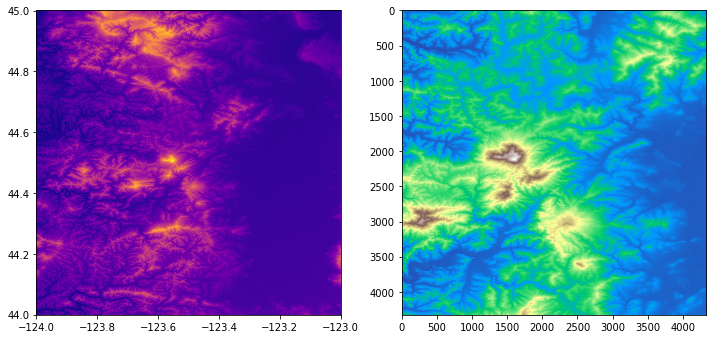

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
#import pycrs
#import eco-eng

def PrintRasterInfo(raster):
    print('Projection:', raster.crs)         # Projection
    print('Shape:' ,raster.shape)
    print('Width:', raster.width)
    print('Height:', raster.height)
    print('Count:',raster.count)
    print('Bounds:',raster.bounds)
    print('Driver:',raster.driver)
    print('NoData Values:',raster.nodatavals)
    print('Meta:',raster.meta)
    return
        

def ClipRasterToCoordBoundingBox(raster,min_x,min_y,max_x,max_y): 
    # clip the the region of interest, coordinate must match raster projection

    # make the bounding box for clipping
    bbox = box(min_x, min_y, max_x, max_y)
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=raster.crs)
    coords = getFeatures(geo)   # get geometry coordinates
    clpRaster, out_transform = mask(raster, coords, crop=True, indexes=1)   # clip to the bounding box
    return clpRaster, out_transform

def ClipRasterToRowColBoundingBox(raster,min_row, min_col, max_row, max_col): 
    # clip the the region of interest, uses cell indices (row/col)scoordinate must match raster projection
    # return 2D array of data, transform of clipped data
    clpRaster = raster[min_row:max_row+1][min_col:max_col+1]
    #clpRaster, out_transform = mask(raster, coords, crop=True, indexes=1)   # clip to the bounding box
    return clpRaster #, out_transform

def ClipRasterToFeatures(raster, features):
    return

#x, y =  np.mgrid[−2:2:20j,0:(2∗pi):20j]
#f = np.exp(−x∗∗2)∗sin(y)
#plt.contourf( f )
#plt.show ( )
#from mpltoolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = Axes3D(fig)
#ax.plotsurface(x,y,f,rtride=1,cstride=1)
#plt.show()


def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

# Read raster bands directly to Numpy arrays.
#
with rasterio.open('../Datasets/imgn45w124_13.img') as src:
    src.read()   # read data into array
    PrintRasterInfo(src)
    
    mid_x = (src.bounds.right + src.bounds.left)/2
    mid_y = (src.bounds.top + src.bounds.bottom)/2
    width = (src.bounds.left - src.bounds.right)
    height = (src.bounds.top - src.bounds.bottom)
    min_x = mid_x-width/5
    max_x = mid_x+width/5
    min_y = mid_y-height/5
    max_y = mid_y+height/5
    
    # clip based on coordinate-based bounding box
    clp_raster, out_transform = ClipRasterToCoordBoundingBox(src,min_x,min_y,max_x,max_y) 
        
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
    show(src, ax=ax1,cmap='plasma')
    ax2.imshow(clp_raster,vmin=0, cmap=plt.get_cmap('terrain'))
    plt.show()

In the output above, note the different x and y axes values.  The first reflects the fact that the `src` object and `show()` function are 'geo-aware', while the clipped raster (`clp_raster`) is just a 2D numpy array without associate spatial information. 


### Saving a Raster Dataset

We can save a raster datase using `rasterio` as well.  The script below saves the clipped dataset `clp_raster` generated in the block above to a new file, transforming the IMG file to GeoTiff format in the process. You can easy get a list of the currently installed GDAL drivers using the example below.

In [ ]:
# save it as a GeoTIFF file by specifying 'driver=GTiff'
shape = clp_raster.shape
with rasterio.open('../Datasets/clpn45w124_13.tif', 'w', driver='GTiff', width=shape[0], height=shape[1],
            count=1, crs=src.crs, transform=out_transform, dtype=src.meta['dtype']) as output:
    output.write(clp_raster,1)  # write data (single band). Note that bands are 1-based
    output.close()

## Reading, (Clipping) and Writing Vector Datasets

In our next example, we will read an Elevation dataset retrieved from the USGS National Map (https://viewer.nationalmap.gov), specifically, the USGS NED Tile n45w124 1/3 arc-second 2013 1 x 1 degree in IMG format,  common raster file type undertood by GDAL. These 1x1 degree datasets consists of a 10812 x 10812 grid, with each cell representing approximately 30m x 30m.  The dataset contains a single **band**, or layer of information, because a single band is sufficient to store elevation values.  Other datasets, particularly imagery, often has multiple bands of information, for example red, green and blue band for an image.

In the example below, we use `rasterio` to read a single-band dataset containing elevation data in the file above, clip the image to a bounding box specified either: 1) the datasets coordinate system, 2) a set of rows and column indices, and 3) a polygonal vector feature or features.

We also demonstrate techniques for displaying raster dataset using `matplotlib` and associated functionality like specifying (colormaps)[https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html] 

Note that `rasterio` provides a function for displaying data on a matplotlib figure, which we take advantage of below.